# Tratamento de um modelo LSTM com Data Generator

## 1. Preparação do Ambiente

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import gdown

# 2. Download do DF

Utilizamos o gdown para baixar o dataset diretamente do Google Drive, pedido pelo professor.


In [2]:
file_id = '1R6AerQn0MuaIYyM1mIhIoYPTD3Qt7SOk'
output = 'dataset.csv'


url = f'https://drive.google.com/uc?id={file_id}'

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1R6AerQn0MuaIYyM1mIhIoYPTD3Qt7SOk
From (redirected): https://drive.google.com/uc?id=1R6AerQn0MuaIYyM1mIhIoYPTD3Qt7SOk&confirm=t&uuid=1757723a-00ca-46db-822d-b9960710f58b
To: /content/dataset.csv
100%|██████████| 683M/683M [00:12<00:00, 53.6MB/s]


'dataset.csv'

# 3. Redução do Tamanho do Dataset

Para tornar o processo de treinamento mais rápido e manejável durante a fase de desenvolvimento, reduzi o tamanho do dataset, utilizando apenas uma fração dos dados originais (por exemplo, 10%)

In [3]:
sample_fraction = 0.1

# Obter o número total de linhas no arquivo
total_rows = sum(1 for line in open('dataset.csv')) - 1

# Calcular o número de linhas a serem lidas
sample_rows = int(total_rows * sample_fraction)

# 4. Leitura e Pré-processamento da Amostra

Nesta etapa, é feita a leitura da amostra definida do dataset e inferi os tipos de dados de cada coluna. Também otimizei esses tipos para tipos mais leves, como int32 em vez de int64, para reduzir o uso de memória. Isso foi feito dado que o dataset é enorme e o Colab não estava suportando.



In [4]:
# amostra
sample_df = pd.read_csv('dataset.csv', nrows=sample_rows)

# obter os tipos de dados
dtypes_dict = sample_df.dtypes.apply(lambda x: x.name).to_dict()
optimized_dtypes = {}
for col, dtype in dtypes_dict.items():
    if dtype == 'int64':
        optimized_dtypes[col] = 'int32'
    elif dtype == 'float64':
        optimized_dtypes[col] = 'float32'
    elif dtype == 'object':
        optimized_dtypes[col] = 'object'
    else:
        optimized_dtypes[col] = dtype

# 5. Preparação dos Encoders e Scalers

Identifiquei as colunas com mais de 10% de dados nulos (dado que eram 500 mil linhas) e as removi para simplificar o modelo. Em seguida, classifiquei as colunas restantes em numéricas e categóricas, preenchendo valores ausentes com valores padrão adequados (-999 para numéricas e ‘missing’ para categóricas). Ajustei os encoders para as variáveis categóricas usando OrdinalEncoder e  as variáveis numéricas usando MinMaxScaler.


In [5]:
# porcentagem dos valores nulos
missing_percentages = sample_df.isnull().mean() * 100

cols_to_drop = missing_percentages[missing_percentages > 10].index.tolist()
print(f"Colunas a serem excluídas devido a mais de 10% de dados nulos: {cols_to_drop}")

sample_df = sample_df.drop(cols_to_drop, axis=1)

Colunas a serem excluídas devido a mais de 10% de dados nulos: ['dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V1

In [6]:
target_col = 'isFraud'

num_cols = sample_df.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.drop(target_col, errors='ignore')
cat_cols = sample_df.select_dtypes(include=['object']).columns

print(f"Colunas numéricas: {list(num_cols)}")
print(f"Colunas categóricas: {list(cat_cols)}")

# valores ausentes em colunas numéricas
sample_df[num_cols] = sample_df[num_cols].fillna(-999)

# valores ausentes em colunas categóricas
sample_df[cat_cols] = sample_df[cat_cols].fillna('missing')

# encoders para as categóricas
ordinal_encoders = {}

for col in cat_cols:
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    sample_df[[col]] = oe.fit_transform(sample_df[[col]].astype(str))
    ordinal_encoders[col] = oe

# scalers para as numéricas
scaler = MinMaxScaler()
sample_df[num_cols] = scaler.fit_transform(sample_df[num_cols])

Colunas numéricas: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']
Colunas categóricas: ['ProductCD', 'card4', 'card6']


# 6. Definição dos Geradores de Dados

Dividi os índices das amostras em conjuntos de treinamento e validação usando train_test_split.

In [7]:
# treinamento e validação
sequence_length = 10
indexes = np.arange(sequence_length, sample_rows)

# divisão em treinamento e validação
train_indexes, val_indexes = train_test_split(
    indexes, test_size=0.2, random_state=42
)

# 7. Implementação do DataGenerator

Classe personalizada DataGenerator que herda de Sequence, permitindo a geração de batches de dados sob demanda durante o treinamento.


In [8]:
class DataGenerator(Sequence):
    def __init__(self, file_path, batch_size, sequence_length, num_features, target_col, dtypes, ordinal_encoders, scaler, indexes, cols_to_drop, total_rows):
        self.file_path = file_path
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.num_features = num_features
        self.target_col = target_col
        self.dtypes = dtypes
        self.ordinal_encoders = ordinal_encoders
        self.scaler = scaler
        self.indexes = indexes
        self.cols_to_drop = cols_to_drop
        self.total_rows = total_rows

    def __len__(self):
        return int(np.ceil(len(self.indexes) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.indexes))
        batch_indexes = self.indexes[start_idx:end_idx]

        if len(batch_indexes) == 0:
            raise IndexError(f'Index {idx} out of range for DataGenerator with length {self.__len__()}')

        batch_indexes = np.sort(batch_indexes)

        start_row = max(0, batch_indexes[0] - self.sequence_length)
        end_row = batch_indexes[-1] + self.sequence_length + 1  # +1 porque read_csv é exclusivo no end_row

        end_row = min(end_row, self.total_rows)

        nrows = end_row - start_row

        if nrows <= 0:
            raise ValueError(f'Invalid nrows ({nrows}) computed for batch {idx}. start_row: {start_row}, end_row: {end_row}')

        # Ler o chunk necessário
        data_chunk = pd.read_csv(
            self.file_path,
            skiprows=range(1, start_row + 1),
            nrows=nrows,
            dtype=self.dtypes
        )

        # Remover as colunas a serem excluídas
        data_chunk = data_chunk.drop(self.cols_to_drop, axis=1)

        data_chunk = self._preprocess_data(data_chunk)

        sequences = []
        labels = []
        for idx_in_batch, idx_original in enumerate(batch_indexes):
            seq_start = idx_original - start_row - self.sequence_length
            seq_end = idx_original - start_row
            if seq_start < 0 or seq_end >= len(data_chunk):
                continue
            seq = data_chunk.iloc[seq_start:seq_end].drop(self.target_col, axis=1).values
            lbl = data_chunk.iloc[seq_end][self.target_col]
            sequences.append(seq)
            labels.append(lbl)

        X = np.array(sequences)
        y = np.array(labels)

        return X, y

    def _preprocess_data(self, df):
        num_cols = df.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.drop(self.target_col, errors='ignore')
        cat_cols = df.select_dtypes(include=['object']).columns

        df[num_cols] = df[num_cols].fillna(-999)
        df[cat_cols] = df[cat_cols].fillna('missing')

        for col in cat_cols:
            oe = self.ordinal_encoders[col]
            df[[col]] = oe.transform(df[[col]].astype(str))

        df[num_cols] = self.scaler.transform(df[num_cols])

        return df


# 8. DataGenerator + Treino e Validação

Instacia dois objetos DataGenerator, um para treinamento e outro para validação, passando todos os parâmetros necessários, incluindo os encoders, scalers e o número total de linhas da amostra.

In [9]:
batch_size = 64
num_features = len(sample_df.columns) - 1  # Excluindo a coluna alvo

train_generator = DataGenerator(
    file_path='dataset.csv',
    batch_size=batch_size,
    sequence_length=sequence_length,
    num_features=num_features,
    target_col=target_col,
    dtypes=optimized_dtypes,
    ordinal_encoders=ordinal_encoders,
    scaler=scaler,
    indexes=train_indexes,
    cols_to_drop=cols_to_drop,
    total_rows=sample_rows
)

val_generator = DataGenerator(
    file_path='dataset.csv',
    batch_size=batch_size,
    sequence_length=sequence_length,
    num_features=num_features,
    target_col=target_col,
    dtypes=optimized_dtypes,
    ordinal_encoders=ordinal_encoders,
    scaler=scaler,
    indexes=val_indexes,
    cols_to_drop=cols_to_drop,
    total_rows=sample_rows
)

# 9. Definição e Compilação do Modelo LSTM

Defini um modelo LSTM simples utilizando a API sequencial do Keras, com uma camada LSTM seguida de uma camada densa com função de ativação sigmoide para classificação binária. (LEMBRAR que o Colab tem limitação de RAM, por isso escolhi o mais simples possívell)

In [10]:
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32)                  │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,721 (73.13 KB)

 Trainable params: 18,721 (73.13 KB)

 Non-trainable params: 0 (0.00 B)

# 10. Cálculo dos Pesos de Classe

Calcula os pesos de classe usando a função compute_class_weight do sklearn para lidar com possíveis desbalanceamentos na variável alvo, isso para que, durante o treinamento, penalize mais as classes minoritárias, ajudando o modelo a aprender.


In [11]:
y_sample = sample_df[target_col].values
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_sample),
    y=y_sample
)
class_weights = dict(enumerate(class_weights))

# 11. Treinamento do Modelo

Treino do modelo utilizando o método fit do Keras, passando o train_generator como fonte de dados. Número de épocas reduzido por conta da RAM e da demora para rodar.


In [12]:
history = model.fit(
    train_generator,
    epochs=2,  # Reduzido para 2 épocas
    validation_data=val_generator,
    class_weight=class_weights
)

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


738/739 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5343 - loss: 0.6912 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


739/739 ━━━━━━━━━━━━━━━━━━━━ 2333s 3s/step - accuracy: 0.5344 - loss: 0.6912 - val_accuracy: 0.9696 - val_loss: 0.5582
Epoch 2/2
739/739 ━━━━━━━━━━━━━━━━━━━━ 2352s 3s/step - accuracy: 0.6804 - loss: 0.6843 - val_accuracy: 0.5343 - val_loss: 0.7002


In [16]:
# Limitar o número de batches para avaliar
max_batches = 100  # Ajuste conforme necessário
y_pred_prob = []
y_true = []

for i, (X_batch, y_batch) in enumerate(val_generator):
    if i >= max_batches:
        break
    y_pred_prob_batch = model.predict_on_batch(X_batch)
    y_pred_prob.extend(y_pred_prob_batch.flatten())
    y_true.extend(y_batch)

# 12. Representação visual

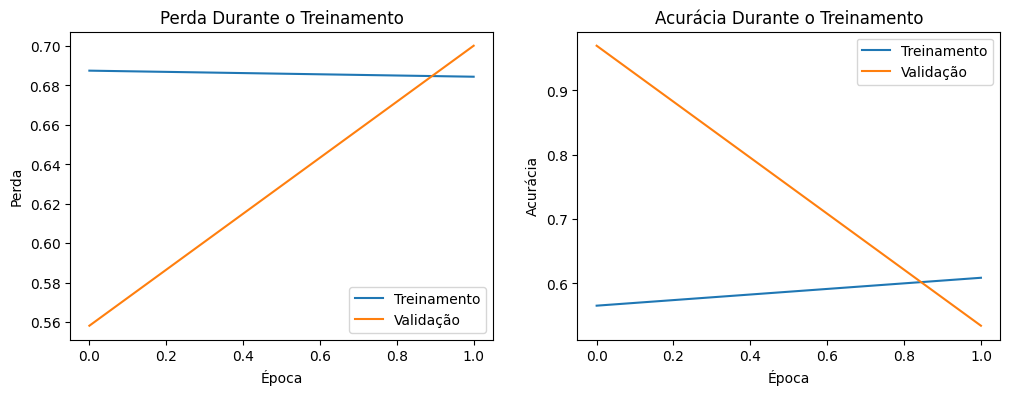

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda Durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia Durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

O modelo claramente está sofrendo overfitting, algo que talvez pudesse ter sido evitado se não tivéssemos removido grande parte do DataFrame